In [1]:
%matplotlib inline

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection
from matplotlib import cm
from collections import Counter

sns.set()

In [148]:
n = 1000
x = np.random.uniform(0, 1, n)
y = np.random.uniform(0, 1, n)
target = norm.pdf((x - 0.75) / 1) + norm.pdf((y - 0.75) / 0.01) \
        + norm.pdf((x - 0.25) / 0.1) + norm.pdf((y - 0.25) / 1) \
        + np.array(np.round(np.random.normal(-0.1,0.1, n), 2))

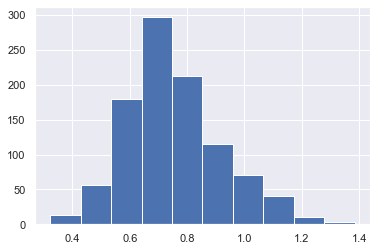

In [151]:
a = plt.hist(target,bins=10)[1]

In [152]:
a

array([0.32276258, 0.42893105, 0.53509952, 0.64126799, 0.74743646,
       0.85360493, 0.9597734 , 1.06594187, 1.17211034, 1.27827881,
       1.38444728])

In [153]:
def f(x):
    for i in range(len(a)):
        if x <= a[i]:
            return i
        else:
            continue   

In [154]:
labels = np.array([f(x) for x in target])

In [155]:
set(labels)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10}

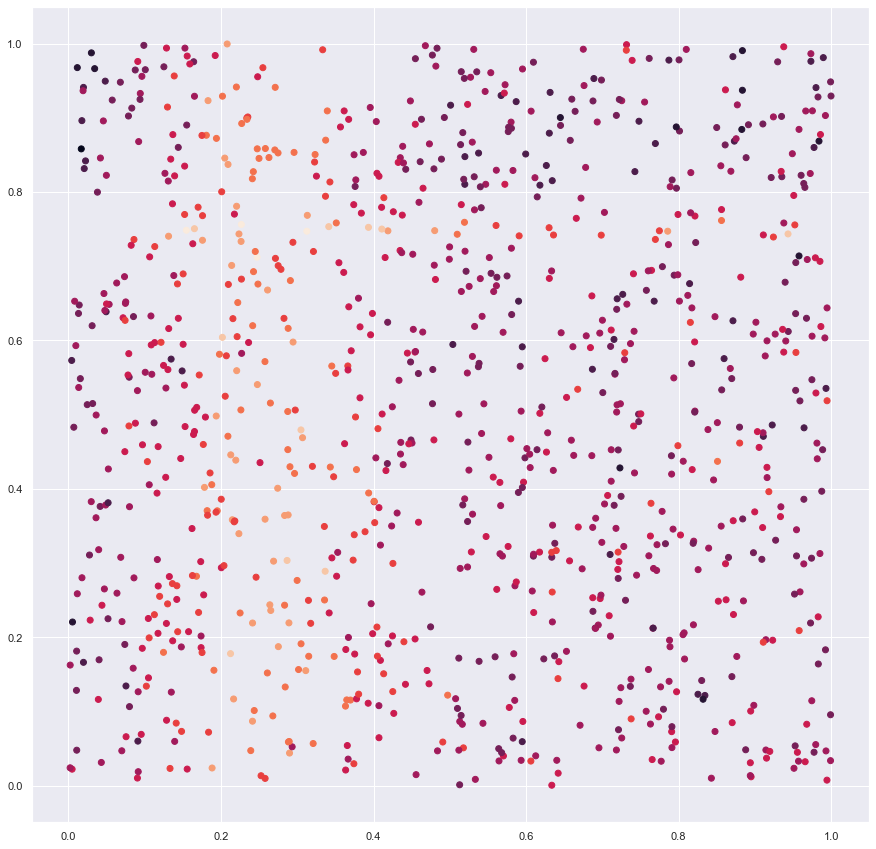

In [156]:
# Plot all points
fig, ax = plt.subplots(figsize = (15,15))
ax.scatter(x, y, c = labels);

In [165]:
data1 = pd.DataFrame({'x' : x, 'y' : y})
tree_1 = DecisionTreeClassifier(max_depth=10,min_samples_leaf = 10,max_features=0.5)
tree_1.fit(data1,labels)

DecisionTreeClassifier(max_depth=10, max_features=0.5, min_samples_leaf=10)

In [166]:
data1

,x,y
0,0.479653,0.701480
1,0.136862,0.877464
2,0.418869,0.747754
3,0.845943,0.412059
4,0.513091,0.086579
...,...,...
995,0.623291,0.170891
996,0.633665,0.314524
997,0.529508,0.867299
998,0.518296,0.817266


In [167]:
def boxes(tree,data,labels):
    
    n_nodes = tree.tree_.node_count
    children_left = tree.tree_.children_left
    children_right = tree.tree_.children_right
    feature = tree.tree_.feature
    threshold = tree.tree_.threshold

    def split(i):
    
        left = children_left[i]
        right = children_right[i]
    
        return (left,right)  


    def parent(i):
        splits = enumerate([split(i) for i in range(n_nodes)])
        for a,b in splits:
            if (b[0] == i) or (b[1] == i):
                return a
            else: continue
    
    
    
    def box(i):
    
        (a,b),(c,d) = (0,0),(0,0)
    
        if i == 0:
            (a,b) = (0,0)
            (c,d) = (1,1)
        else:
            j = parent(i)
            t = threshold[j]
            (a,b),(c,d) = box(j)
            
            if feature[j] == 0:
                if i == split(j)[0]:
                    (a,b) = (a,b)
                    (c,d) = (t,d)
                else:
                    (a,b) = (t,b)
                    (c,d) = (c,d)
                    
            if feature[j] == 1:
                if i == split(j)[0]:
                    (a,b) = (a,b)
                    (c,d) = (c,t)
                else:
                    (a,b) = (a,t)
                    (c,d) = (c,d)
                
        return (a,b),(c,d)

    boxes = []
    for i in range(n_nodes):
        boxes.append(box(i))
        
    fig, ax = plt.subplots(figsize = (10,10))
    ax.scatter(x, y, c = target);



    for i in range(1,n_nodes):
    
        j = parent(i)
        t = threshold[j]
        ((a,b),(c,d)) = boxes[j]
        if feature[j] == 0:
            ax.vlines(t, b, d, colors='k')
        else:
            ax.hlines(t,a,c,colors='k') 
            
    leaves = [x for x in range(n_nodes) if split(x) == (-1,-1)]
    
    leaf_rects = []
    for leaf in leaves:
        ((a,b),(c,d)) = box(leaf)
        rect = Rectangle((a,b), c - a,d - b )
        leaf_rects.append(rect)
        
    
    facecolor = []
    for leaf in leaves:
        data_points_in_rect = []
        for i in range(len(data1)):
            p = data1.iloc[i]
            ((a,b),(c,d)) = boxes[leaf]
            if (p['x'] > a) and (p['x'] <= c) and (p['y'] > b) and (p['y'] <= d):
                data_points_in_rect.append(i)
        color = cm.prism_r( 15*Counter(labels[data_points_in_rect]).most_common()[0][0] + 10)
        facecolor.append(color)  
    
    pc = PatchCollection(leaf_rects, facecolor=facecolor, alpha=0.9,
                         edgecolor='k',linewidths = (10,))
        
    fig,ax = plt.subplots(figsize = (10,10))
    ax.add_collection(pc);

In [168]:
Counter(labels).most_common()[0][0]

4

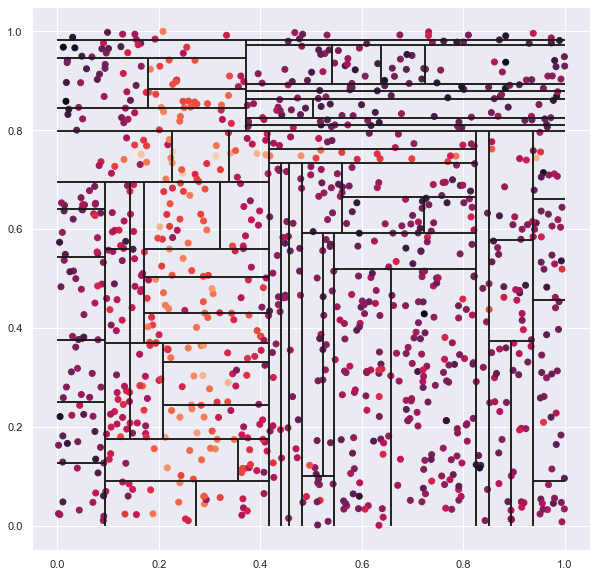

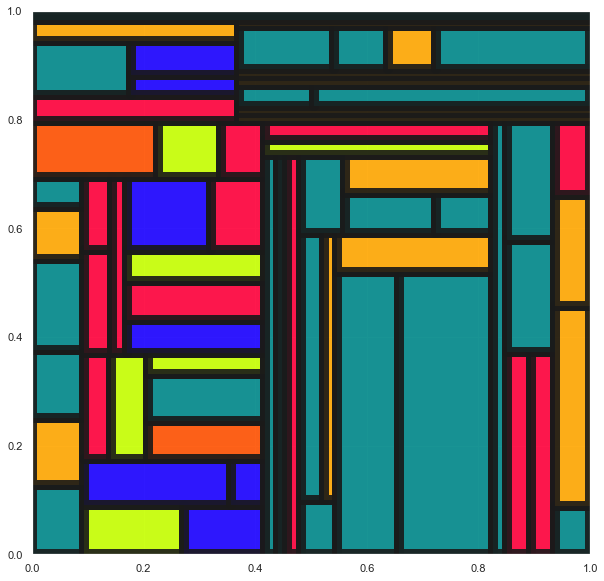

In [169]:
boxes(tree_1,data1,labels)    

In [146]:
from sklearn.ensemble import BaggingClassifier

In [15]:
bg_clf = BaggingClassifier(DecisionTreeClassifier(min_samples_leaf=32),n_estimators=10,max_samples=0.4)

In [ ]:
bg_clf.fit(data1,labels)

In [ ]:
trees = bg_clf.estimators_

In [ ]:
def bagging_boxes(tree,data,labels):
    
    n_nodes = tree.tree_.node_count
    children_left = tree.tree_.children_left
    children_right = tree.tree_.children_right
    feature = tree.tree_.feature
    threshold = tree.tree_.threshold

    def split(i):
    
        left = children_left[i]
        right = children_right[i]
    
        return (left,right)  


    def parent(i):
        splits = enumerate([split(i) for i in range(n_nodes)])
        for a,b in splits:
            if (b[0] == i) or (b[1] == i):
                return a
            else: continue
    
    
    
    def box(i):
    
        (a,b),(c,d) = (0,0),(0,0)
    
        if i == 0:
            (a,b) = (0,0)
            (c,d) = (1,1)
        else:
            j = parent(i)
            t = threshold[j]
            (a,b),(c,d) = box(j)
            
            if feature[j] == 0:
                if i == split(j)[0]:
                    (a,b) = (a,b)
                    (c,d) = (t,d)
                else:
                    (a,b) = (t,b)
                    (c,d) = (c,d)
                    
            if feature[j] == 1:
                if i == split(j)[0]:
                    (a,b) = (a,b)
                    (c,d) = (c,t)
                else:
                    (a,b) = (a,t)
                    (c,d) = (c,d)
                
        return (a,b),(c,d)

    boxes = []
    for i in range(n_nodes):
        boxes.append(box(i))
        

    leaves = [x for x in range(n_nodes) if split(x) == (-1,-1)]
    
    leaf_rects = []
    for leaf in leaves:
        ((a,b),(c,d)) = box(leaf)
        rect = Rectangle((a,b), c - a,d - b )
        leaf_rects.append(rect)
        
    
    facecolor = []
    for leaf in leaves:
        points_in_rect = []
        for i in range(len(data1)):
            p = data1.iloc[i]
            ((a,b),(c,d)) = boxes[leaf]
            if (p['x'] > a) and (p['x'] <= c) and (p['y'] > b) and (p['y'] <= d):
                points_in_rect.append(i)
        color = cm.prism_r(7*np.max([labels[points_in_rect]])-5)
        facecolor.append(color)  
    
    pc = PatchCollection(leaf_rects, facecolor=facecolor, alpha=0.1,
                         edgecolor='k',linewidths = (2,))
        

    ax.add_collection(pc);


In [ ]:
fig, ax = plt.subplots(figsize = (10,10))

for tree in trees:
    bagging_boxes(tree,data1,labels)